In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import f1_score
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, RFECV, chi2, f_classif, mutual_info_classif
 
import warnings
warnings.filterwarnings('ignore')
pd.pandas.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('forest_fire.csv')

In [3]:
df.shape

(55367, 43)

In [4]:
# drop rows with missing data
df = df[df['Temp_cont'] != -1]

to_drop = ['Unnamed: 0', 'Unnamed: 0.1', 'fire_name',
           'cont_clean_date', 'disc_date_final', 'cont_date_final', 
           'putout_time', 'disc_date_pre', 'disc_pre_year', 
           'disc_pre_month', 'wstation_usaf', 'dstation_m',
           'wstation_wban', 'wstation_byear', 'wstation_eyear',
           'fire_mag', 'weather_file', 'Temp_cont', 'Hum_cont',
           'Wind_cont', 'Prec_cont']

df = df.drop(labels=to_drop, axis=1)

In [5]:
# convert temperatures from Celcius to Fahrenheit
def c_to_f(c):
    return (c * 9/5) + 32

df.loc[:,'Temp_pre_30':'Temp_pre_7'] = df.loc[:,'Temp_pre_30':'Temp_pre_7'].applymap(lambda x: c_to_f(x))

In [6]:
# remove rows where 'missing values' that have been replaced by 0C/32F
df = df[(df.Temp_pre_30!=float(32))]
df = df[(df.Temp_pre_15!=float(32))]
df = df[(df.Temp_pre_7!=float(32))]

In [7]:
df.shape

(36535, 22)

In [8]:
df.fire_size_class.value_counts(normalize=True) # noticing a class imbalance here

B    0.647708
C    0.194060
G    0.080252
F    0.039168
D    0.025756
E    0.013056
Name: fire_size_class, dtype: float64

## Create Target Variable

In [9]:
df['target'] = np.where(df['fire_size'] <= 100,0,1)

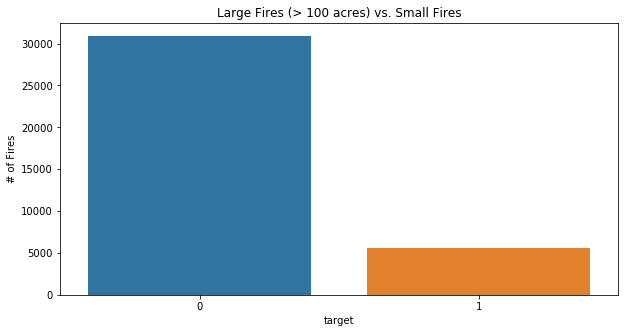

In [10]:
plt.figure(figsize=(10,5))
sns.countplot(df['target'])
plt.title('Large Fires (> 100 acres) vs. Small Fires')
plt.ylabel('# of Fires')
plt.show()

In [11]:
df.describe()

,fire_size,latitude,longitude,Vegetation,Temp_pre_30,Temp_pre_15,Temp_pre_7,Wind_pre_30,Wind_pre_15,Wind_pre_7,Hum_pre_30,Hum_pre_15,Hum_pre_7,Prec_pre_30,Prec_pre_15,Prec_pre_7,remoteness,target
count,36535.000000,36535.000000,36535.000000,36535.000000,36535.000000,36535.000000,36535.000000,36535.000000,36535.000000,36535.000000,36535.000000,36535.000000,36535.000000,36535.000000,36535.000000,36535.000000,36535.000000,36535.000000
mean,2333.094280,36.660711,-95.897825,11.043602,60.836480,61.780976,62.454035,3.142058,3.129052,3.104218,58.613043,57.609115,56.462198,39.472134,17.989741,7.496871,0.244771,0.153989
std,15370.623847,6.901523,16.099409,5.584928,15.342448,15.073362,15.131889,1.200735,1.248833,1.332299,17.258248,17.601590,18.070949,135.670076,69.206011,38.111117,0.147181,0.360943
min,0.510000,17.958364,-165.116700,0.000000,6.510518,0.736096,-5.522988,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.150000,32.446761,-104.761750,9.000000,49.089291,50.133548,50.828285,2.333406,2.285050,2.202799,53.025187,51.308131,48.821073,0.000000,0.000000,0.000000,0.140430,0.000000
50%,4.000000,34.815135,-93.251333,12.000000,60.906686,61.827082,62.792857,3.062696,3.044966,2.997159,63.548101,62.273349,60.682353,3.000000,0.000000,0.000000,0.210037,0.000000
75%,21.000000,40.335693,-83.646370,15.000000,73.949175,74.615478,75.221471,3.864361,3.872146,3.883929,69.784996,69.284457,68.708757,43.500000,15.600000,2.500000,0.294780,0.000000
max,538049.000000,69.047200,-65.417709,16.000000,115.880000,124.822034,131.000000,25.700000,25.700000,25.700000,94.000000,94.000000,96.000000,13560.800000,2527.000000,1638.000000,1.000000,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcbd5bf34a8>,
      dtype=object)

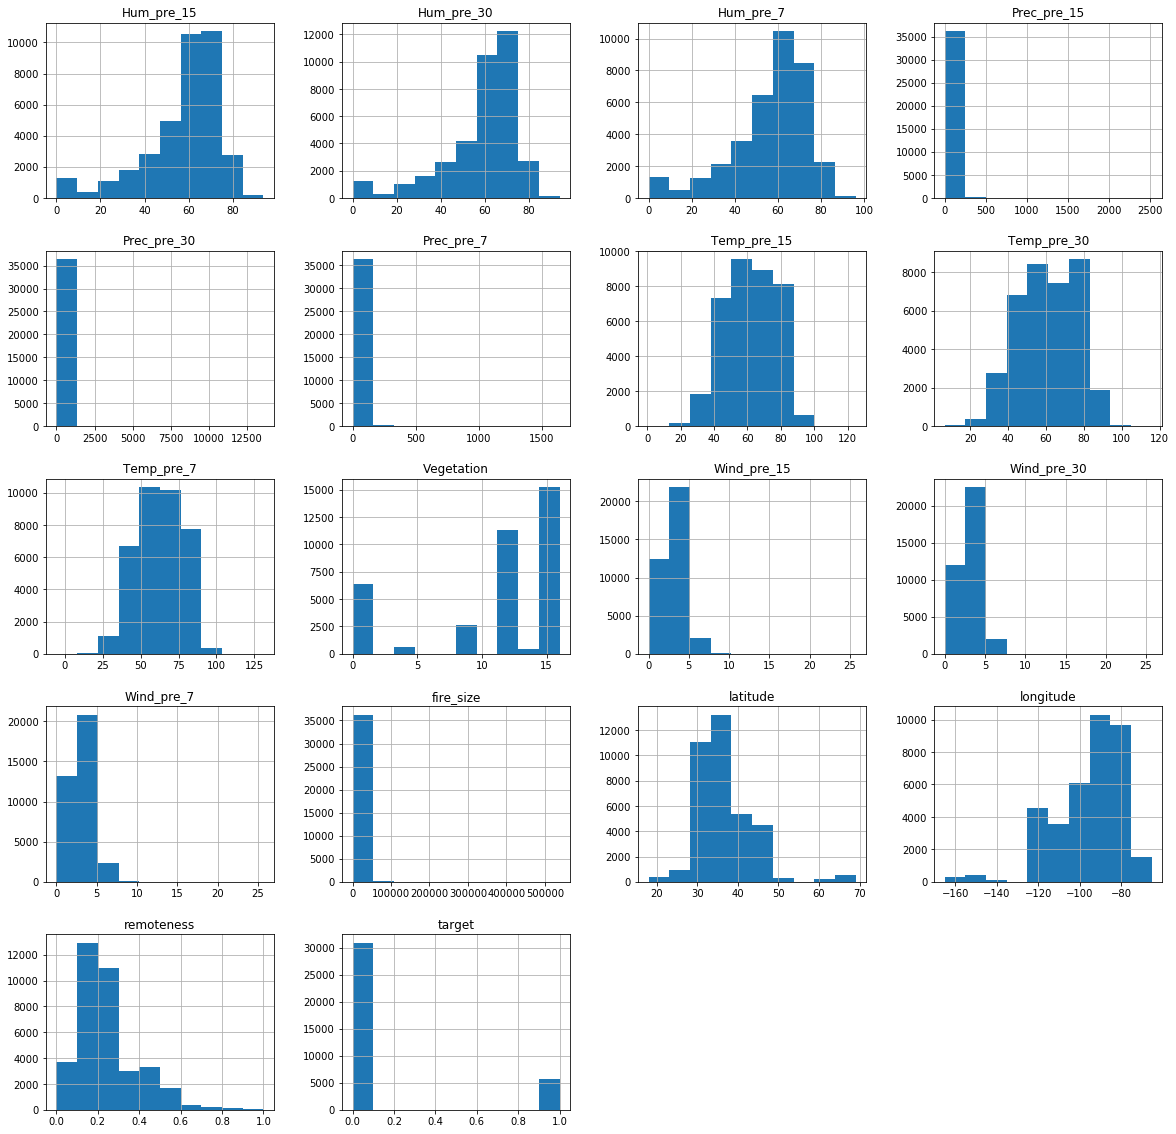

In [12]:
df.hist(figsize=(20,20))

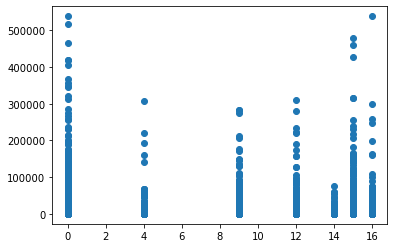

In [13]:
plt.scatter(df['Vegetation'], df['fire_size'])

#### Hum_cont v Fire_Size

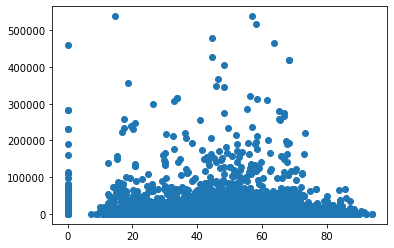

In [14]:
plt.scatter(df['Hum_pre_30'], df['fire_size'])

#### Prec-cont vs Fire_Size

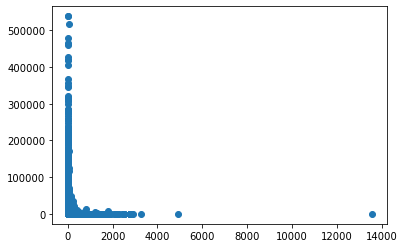

In [15]:
plt.scatter(df['Prec_pre_30'], df['fire_size'])

#### Temp_cont vs. Fire_Size

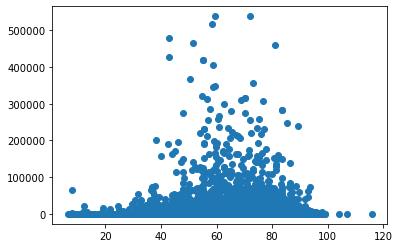

In [16]:
plt.scatter(df['Temp_pre_30'], df['fire_size'])

#### Wind_cont vs. Fire_Size

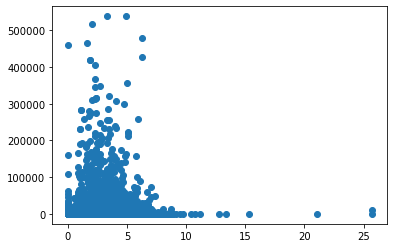

In [17]:
plt.scatter(df['Wind_pre_30'], df['fire_size'])

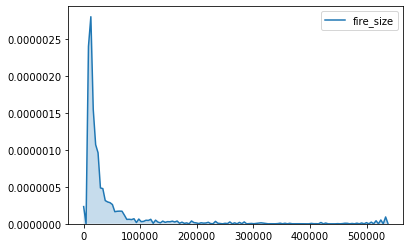

In [18]:
# spread of fires by acres burned, play with the Xlim to see more or less of the distribution
sns.kdeplot(df['fire_size'], shade=True)#.set_xlim(0,50000)

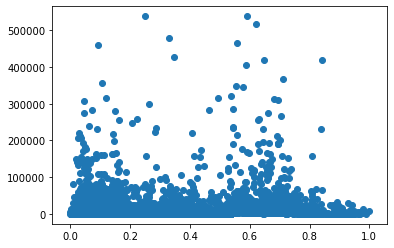

In [19]:
plt.scatter(df['remoteness'],df['fire_size'])

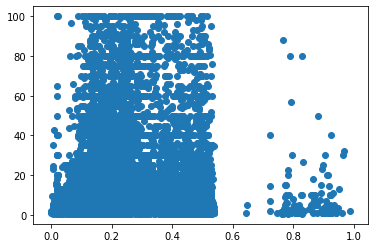

In [20]:
# sns.scatterplot(df['remoteness'], df['fire_size'], hue=df['target'],)
smalls = df[df['target'] == 0]

plt.scatter(smalls['remoteness'], smalls['fire_size'])

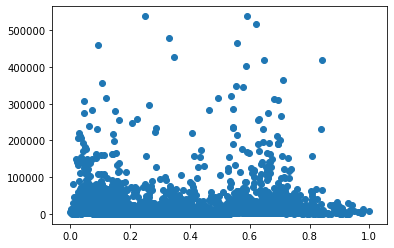

In [21]:
large = df[df['target'] == 1]

plt.scatter(large['remoteness'], large['fire_size'])

Text(0.5, 1.0, 'Large Fires')

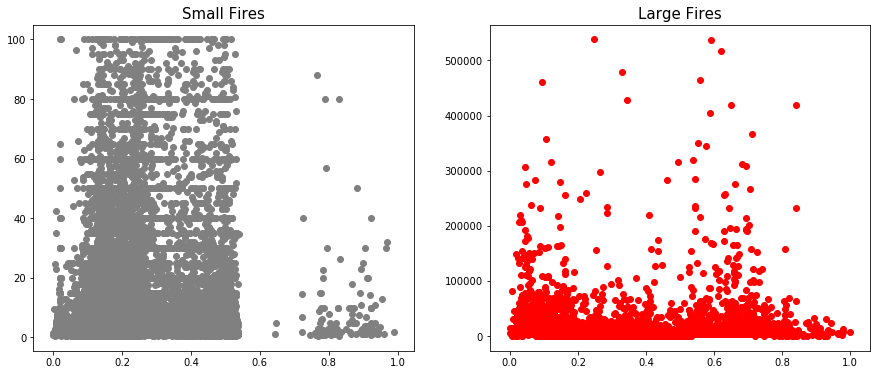

In [22]:
fig = plt.figure(figsize=(15,6))
ax = fig.subplots(1,2)

smalls = df[df['target'] == 0]
large = df[df['target'] == 1]

ax[0].scatter(smalls['remoteness'], smalls['fire_size'], color='grey')
ax[0].set_title('Small Fires', fontsize=15)

ax[1].scatter(large['remoteness'], large['fire_size'], color='red')
ax[1].set_title('Large Fires', fontsize=15)

Text(0.5, 1.0, 'Large Fires Remoteness')

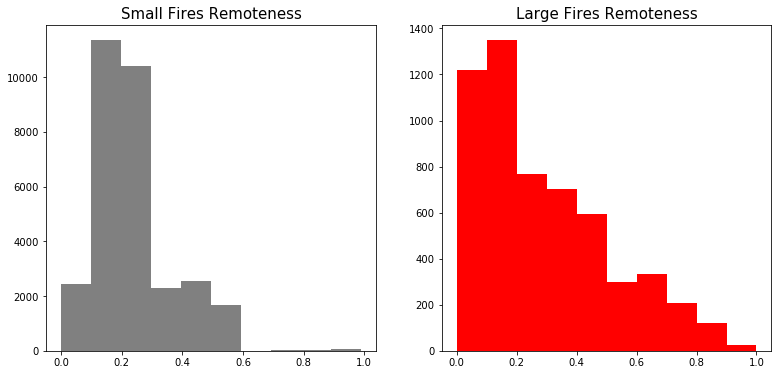

In [23]:
fig = plt.figure(figsize=(13,6))
ax = fig.subplots(1,2)

smalls = df[df['target'] == 0]
large = df[df['target'] == 1]

ax[0].hist(smalls['remoteness'], color='grey')
ax[0].set_title('Small Fires Remoteness', fontsize=15)

ax[1].hist(large['remoteness'], color='red')
ax[1].set_title('Large Fires Remoteness', fontsize=15)

(0, 2000)

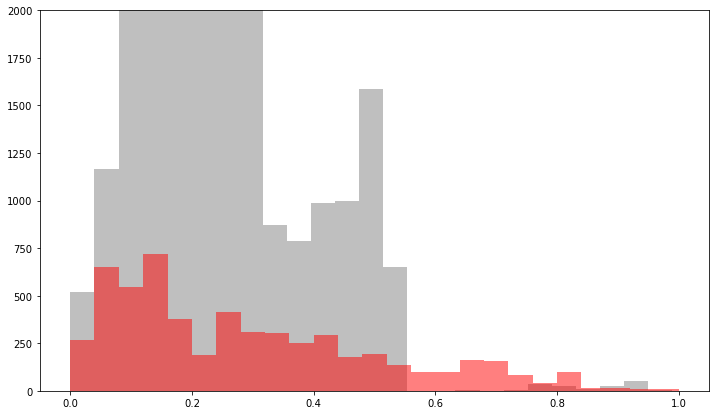

In [24]:
plt.figure(figsize=(12,7))
plt.hist(smalls['remoteness'], bins=25, alpha=0.5, label='Small Fires', color='grey')
plt.hist(large['remoteness'], bins=25, alpha=0.5, label='Large Fires', color='red')
plt.ylim(0,2000)

### Target Visuals

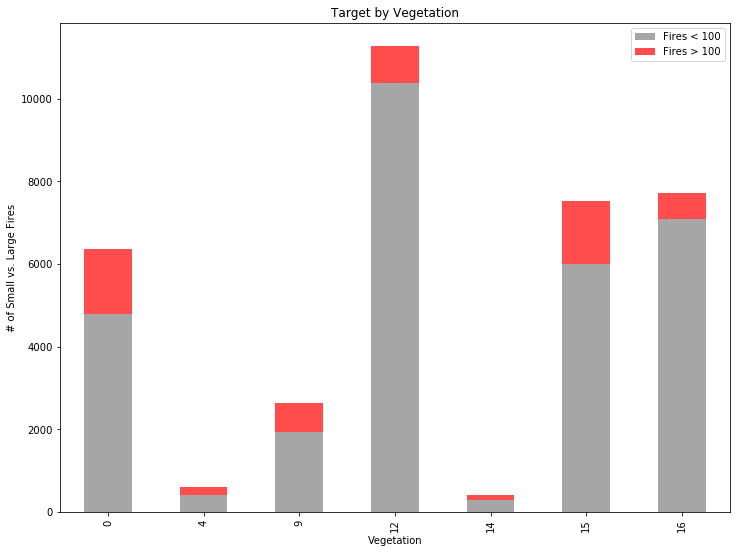

In [25]:
vegetation_viz = df.groupby(['Vegetation', 'target']).Vegetation.count().unstack()

p1 = vegetation_viz.plot(kind='bar', stacked=True, title='Target by Vegetation', color=['grey', 'red'], alpha=.70, figsize=(12,9))
p1.set_xlabel('Vegetation')
p1.set_ylabel('# of Small vs. Large Fires')
p1.legend(['Fires < 100', 'Fires > 100'])
plt.show()

**Vegetation**

0: Unknown

4: Temperate Evergreen Needleleaf Forest

9: C3 Grassland/Steppe

12: Open Shrubland

14: Desert

15: Polar Desert/Rock/Ice

16: Secondary Tropical Evergreen Broadleaf Forest

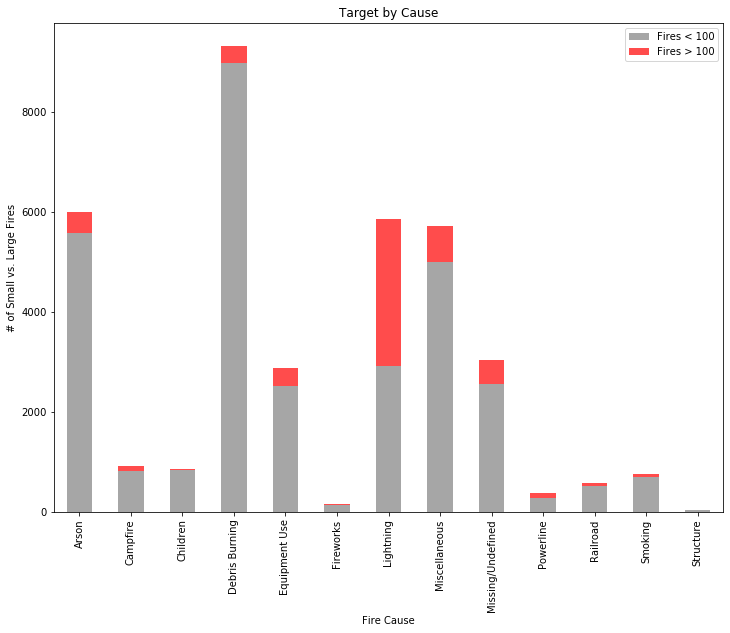

In [26]:
cause_viz = df.groupby(['stat_cause_descr', 'target']).stat_cause_descr.count().unstack()

p2 = cause_viz.plot(kind='bar', stacked=True, title='Target by Cause', color=['grey', 'red'], alpha=.70, figsize=(12,9))
p2.set_xlabel('Fire Cause')
p2.set_ylabel('# of Small vs. Large Fires')
p2.legend(['Fires < 100', 'Fires > 100'])
plt.show()

In [27]:
df['month'] = df['discovery_month'].apply(lambda x: 
                                         1 if x == 'Jan'
                                          else 2 if x == 'Feb'
                                          else 3 if x == 'Mar'
                                          else 4 if x == 'Apr'
                                          else 5 if x == 'May'
                                          else 6 if x == 'Jun'
                                          else 7 if x == 'Jul'
                                          else 8 if x == 'Aug'
                                          else 9 if x == 'Sep'
                                          else 10 if x == 'Oct'
                                          else 11 if x == 'Nov'
                                          else 12
                                         )

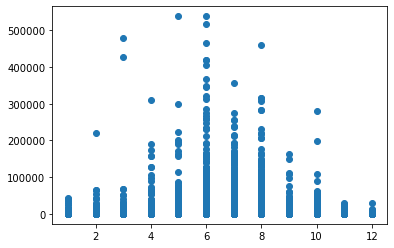

In [28]:
plt.scatter(df['month'], df['fire_size'])

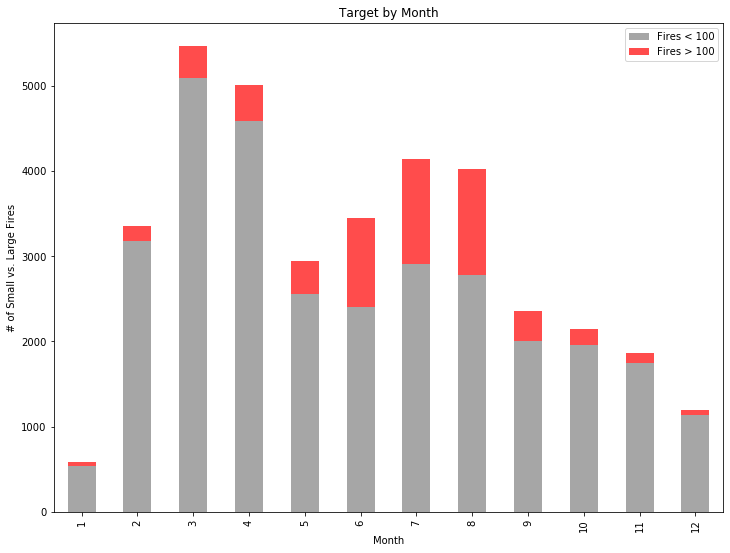

In [29]:
#### JUN/JUL/AUG have the most big fires out of the year ####

month_viz = df.groupby(['month', 'target']).month.count().unstack()

p3 = month_viz.plot(kind='bar', stacked=True, title='Target by Month', color=['grey', 'red'], alpha=.70, figsize=(12,9))
p3.set_xlabel('Month')
p3.set_ylabel('# of Small vs. Large Fires')
p3.legend(['Fires < 100', 'Fires > 100'])
plt.show()

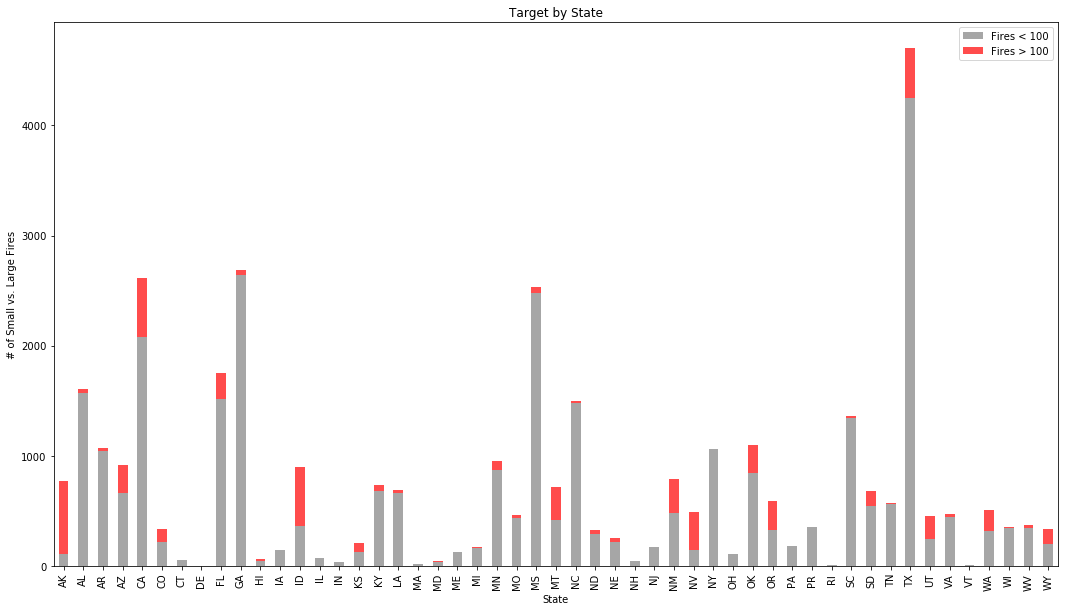

In [30]:
state_viz = df.groupby(['state', 'target']).state.count().unstack()

p4 = state_viz.plot(kind='bar', stacked=True, title='Target by State', color=['grey', 'red'], alpha=.70, figsize=(18,10))
p4.set_xlabel('State')
p4.set_ylabel('# of Small vs. Large Fires')
p4.legend(['Fires < 100', 'Fires > 100'])
plt.show()

In [31]:
df['year'] = df['disc_clean_date'].apply(lambda x: int(x[-4:]))

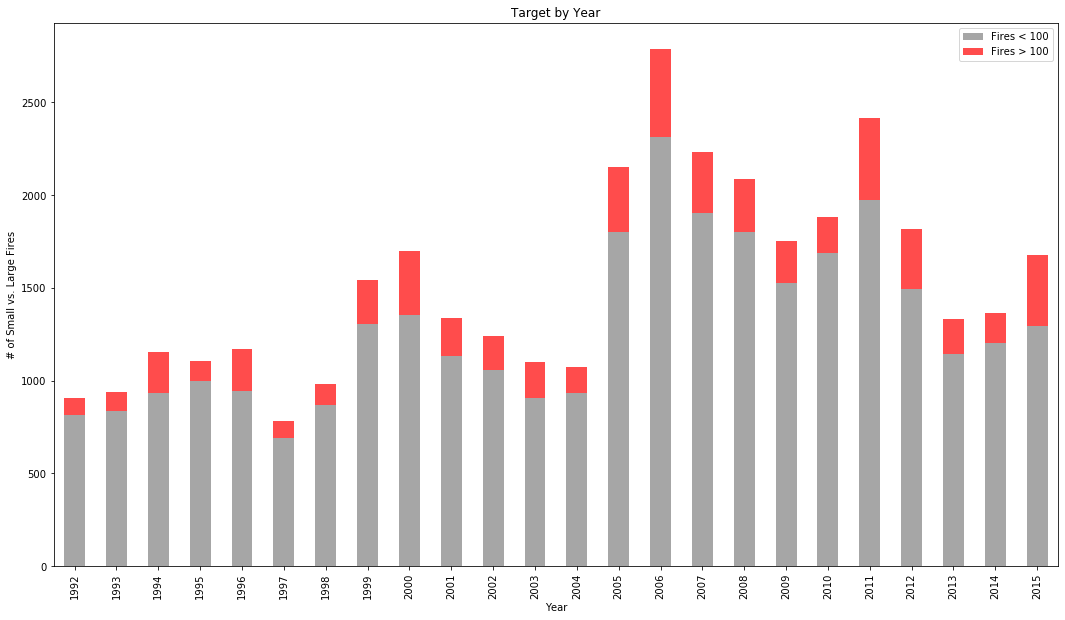

In [32]:
year_viz = df.groupby(['year', 'target']).year.count().unstack()

p5 = year_viz.plot(kind='bar', stacked=True, title='Target by Year', color=['grey', 'red'], alpha=.70, figsize=(18,10))
p5.set_xlabel('Year')
p5.set_ylabel('# of Small vs. Large Fires')
p5.legend(['Fires < 100', 'Fires > 100'])
plt.show()

In [33]:
small_acres_df = df[df['target'] == 0]
small_acres = small_acres_df.groupby('year').fire_size.sum()

large_acres_df = df[df['target'] == 1]
large_acres = large_acres_df.groupby('year').fire_size.sum()

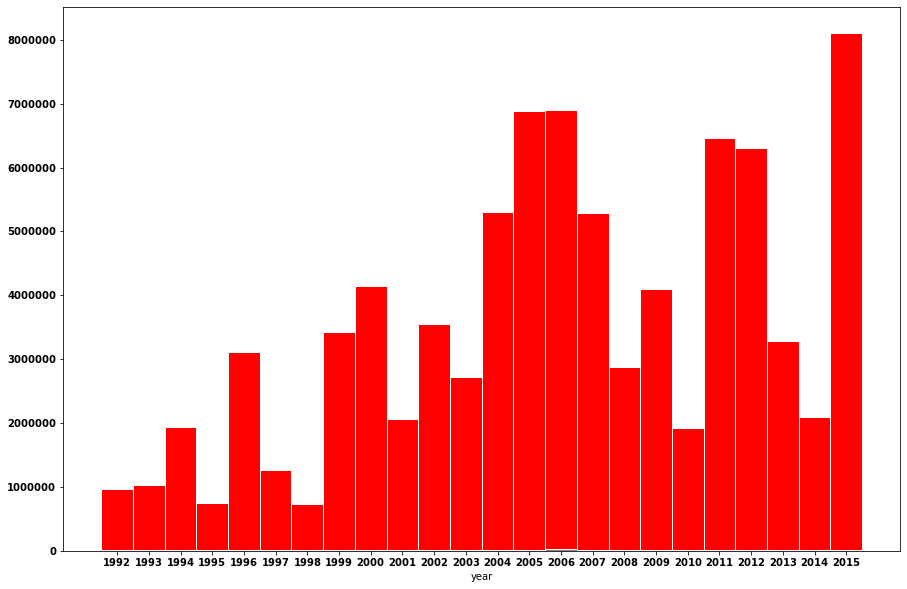

In [34]:
from matplotlib import rc
plt.figure(figsize=(15,10))
rc('font', weight='bold')

bars1 = list(small_acres)
bars2 = list(large_acres)

bars = np.add(bars1, bars2).tolist()

r = sorted(list(df['year'].unique()))

names = sorted(list(df['year'].unique()))

barWidth = 1

plt.bar(r, bars1, color='grey', edgecolor='white', width=barWidth)
plt.bar(r, bars2, bottom=bars1, color='red', edgecolor='white', width=barWidth)

plt.xticks(r, names, fontweight='bold')
plt.xlabel('year')

plt.show()

### there is grey in this graph ###

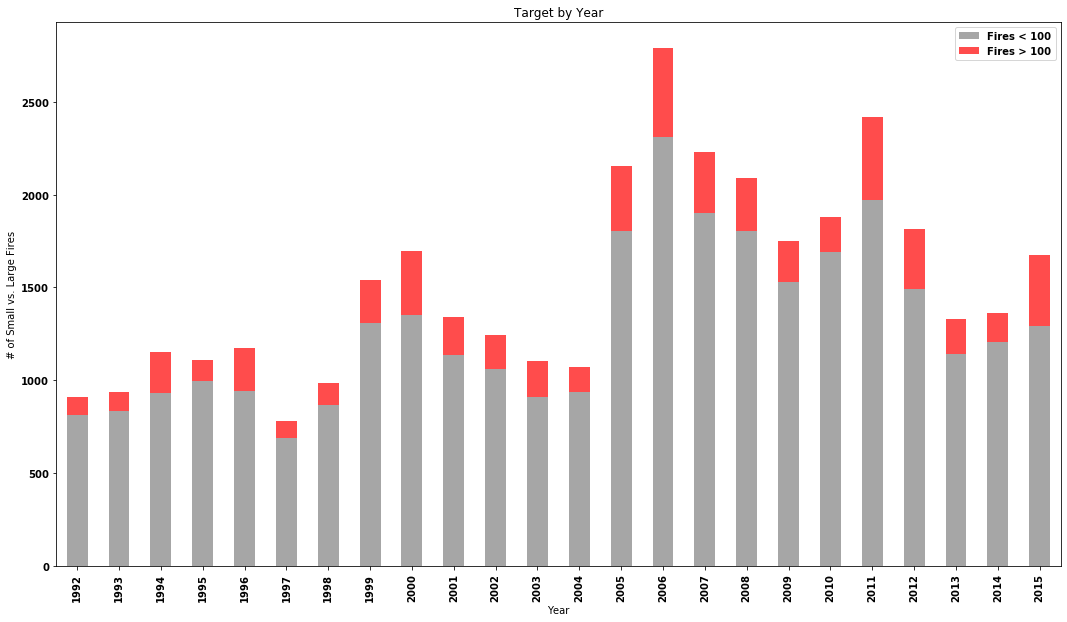

In [35]:
year_acres = df.groupby(['year', 'target']).year.count().unstack()

p6 = year_viz.plot(kind='bar', stacked=True, title='Target by Year', color=['grey', 'red'], alpha=.70, figsize=(18,10))
p6.set_xlabel('Year')
p6.set_ylabel('# of Small vs. Large Fires')
p6.legend(['Fires < 100', 'Fires > 100'])
plt.show()

In [36]:
df.groupby('year')['target'].value_counts(normalize=True)  # 2015 was the only year that Big fires made up >20% of fires

year  target
1992  0         0.896590
      1         0.103410
1993  0         0.890075
      1         0.109925
1994  0         0.807626
      1         0.192374
1995  0         0.902351
      1         0.097649
1996  0         0.803754
      1         0.196246
1997  0         0.883483
      1         0.116517
1998  0         0.882114
      1         0.117886
1999  0         0.848052
      1         0.151948
2000  0         0.796820
      1         0.203180
2001  0         0.845522
      1         0.154478
2002  0         0.851971
      1         0.148029
2003  0         0.824705
      1         0.175295
2004  0         0.871269
      1         0.128731
2005  0         0.836972
      1         0.163028
2006  0         0.828612
      1         0.171388
2007  0         0.852084
      1         0.147916
2008  0         0.863092
      1         0.136908
2009  0         0.871575
      1         0.128425
2010  0         0.898458
      1         0.101542
2011  0         0.815887
      1     

In [37]:
df.groupby('year').fire_size.sum()

year
1992    9.692334e+05
1993    1.031197e+06
1994    1.941767e+06
1995    7.547969e+05
1996    3.107279e+06
1997    1.272952e+06
1998    7.271575e+05
1999    3.423711e+06
2000    4.146355e+06
2001    2.059546e+06
2002    3.553245e+06
2003    2.715347e+06
2004    5.299413e+06
2005    6.889104e+06
2006    6.902563e+06
2007    5.282276e+06
2008    2.884323e+06
2009    4.095423e+06
2010    1.925282e+06
2011    6.457579e+06
2012    6.302345e+06
2013    3.291098e+06
2014    2.100844e+06
2015    8.106764e+06
Name: fire_size, dtype: float64

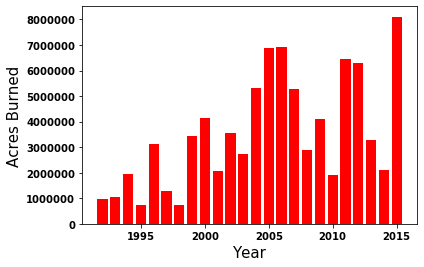

In [38]:
# checking to confirm a rise in fire size 
years = range(1992,2016,1)

fire_sizes = df.groupby('year').fire_size.sum()

plt.bar(years, fire_sizes, color='red')
plt.xlabel('Year', fontsize=15)
plt.ylabel('Acres Burned', fontsize=15)
plt.show()

Text(0.5, 1.0, 'long')

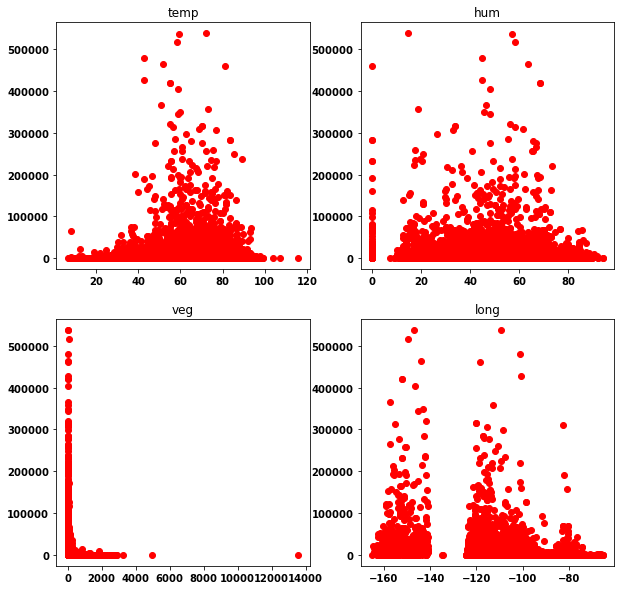

In [39]:
fig = plt.figure(figsize=(10,10))
ax = fig.subplots(2,2)
y = df.fire_size
x1 = df.Temp_pre_30
x2 = df.Hum_pre_30
x3 = df.Prec_pre_30
x4 = df.longitude
ax[0,0].scatter(x1,y,color='red')
ax[0,0].set_title('temp')
ax[0,1].scatter(x2,y,color='red')
ax[0,1].set_title('hum')
ax[1,0].scatter(x3,y,color='red')
ax[1,0].set_title('veg')
ax[1,1].scatter(x4,y,color='red')
ax[1,1].set_title('long')

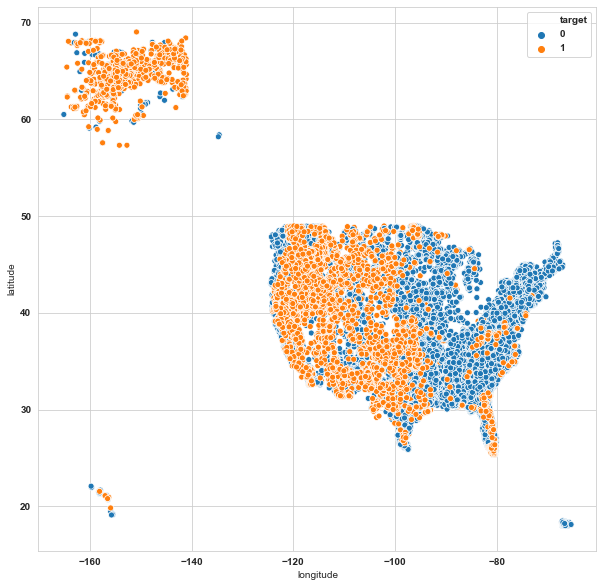

In [40]:
sns.set_style("whitegrid")

x = df.longitude
y = df.latitude

fig = plt.figure(figsize=(10,10))
ax = fig.subplots
ax = sns.scatterplot(x=x, y=y,
              hue=df.target,
              data=df);

## Feature Engineering

#### [cold_front'] 
(http://www.nationalfirefighter.com/blog/Effects-of-Weather-Conditions-on-Wildfire-Suppression)

In [41]:
df['temp_avg'] = (df['Temp_pre_30']+df['Temp_pre_15']+df['Temp_pre_7'])/3

In [42]:
df[['Temp_pre_30', 'Temp_pre_15', 'Temp_pre_7', 'temp_avg']].describe()

,Temp_pre_30,Temp_pre_15,Temp_pre_7,temp_avg
count,36535.000000,36535.000000,36535.000000,36535.000000
mean,60.836480,61.780976,62.454035,61.690497
std,15.342448,15.073362,15.131889,14.995829
min,6.510518,0.736096,-5.522988,1.892735
25%,49.089291,50.133548,50.828285,50.112659
50%,60.906686,61.827082,62.792857,61.704819
75%,73.949175,74.615478,75.221471,74.558734
max,115.880000,124.822034,131.000000,119.156065


#### ['is_remote']

In [43]:
df['is_remote'] = np.where(df['remoteness'] > 0.6,1,0)

#### [ 'did_rain']

In [44]:
cond = [
    (df['Prec_pre_7'] != 0) | (df['Prec_pre_15'] != 0) | (df['Prec_pre_30'] != 0)
]
choice = [
    1
]
df['did_rain'] = np.select(cond,choice,default=0)

#### ['binning_temp']

In [45]:
cond = [
    df.Temp_pre_30 <= np.quantile(df.Temp_pre_30,0.25),
    df.Temp_pre_30 <= np.quantile(df.Temp_pre_30,0.5),
    df.Temp_pre_30 <= np.quantile(df.Temp_pre_30,0.75),
    df.Temp_pre_30 <= np.quantile(df.Temp_pre_30,1),
]
out = [
    0,
    1,
    2,
    3
]
df['Temp_pre_30_bin'] = np.select(cond,out)

cond = [
    df.Temp_pre_15 <= np.quantile(df.Temp_pre_15,0.25),
    df.Temp_pre_15 <= np.quantile(df.Temp_pre_15,0.5),
    df.Temp_pre_15 <= np.quantile(df.Temp_pre_15,0.75),
    df.Temp_pre_15 <= np.quantile(df.Temp_pre_15,1),
]
out = [
    0,
    1,
    2,
    3
]
df['Temp_pre_15_bin'] = np.select(cond,out)

cond = [
    df.Temp_pre_7 <= np.quantile(df.Temp_pre_7,0.25),
    df.Temp_pre_7 <= np.quantile(df.Temp_pre_7,0.5),
    df.Temp_pre_7 <= np.quantile(df.Temp_pre_7,0.75),
    df.Temp_pre_7 <= np.quantile(df.Temp_pre_7,1),
]
out = [
    0,
    1,
    2,
    3
]
df['Temp_pre_7_bin'] = np.select(cond,out)

#### Dummy Dataframe

In [46]:
df.Vegetation = df.Vegetation.astype('O')

dummies = ['discovery_month', 'state', 'Vegetation']

df = pd.get_dummies(df, columns=dummies, drop_first=True) # adds 67 columns, and we remove the 3 originals, total of 64 dummy columns

#### ['binning_longitude']

In [47]:
cond = [
    df.longitude <= np.quantile(df.longitude,0.25),
    df.longitude <= np.quantile(df.longitude,0.5),
    df.longitude <= np.quantile(df.longitude,0.75),
    df.longitude <= np.quantile(df.longitude,1),
]
out = [
    0,
    1,
    2,
    3
]
df['longitude_bin'] = np.select(cond,out)

#### ['west_coast']

In [48]:
df['west_coast'] = df.longitude.apply(lambda x: 1 if x < -100 else 0)

#### ['is_very_windy']

In [49]:
df['very_windy_30'] = df.Wind_pre_30.apply(lambda x: 1 if x > 4 else 0)
df['very_windy_15'] = df.Wind_pre_30.apply(lambda x: 1 if x > 4 else 0)
df['very_windy_7'] = df.Wind_pre_30.apply(lambda x: 1 if x > 4 else 0)

In [50]:
df['Hum_pre_30'].head()

0    78.216590
1    70.840000
2    75.531629
3    44.778429
7    72.899478
Name: Hum_pre_30, dtype: float64

#### ['is_humid']

In [51]:
df['low_humid_30'] = df.Hum_pre_30.apply(lambda x: 1 if x < 50 else 0)
df['low_humid_15'] = df.Hum_pre_15.apply(lambda x: 1 if x < 50 else 0)
df['low_humid_7'] = df.Hum_pre_7.apply(lambda x: 1 if x < 50 else 0)

In [52]:
conditions = [df['stat_cause_descr'] == 'Missing/Undefined',
 df['stat_cause_descr'] == 'Arson',
 df['stat_cause_descr'] == 'Debris Burning',
 df['stat_cause_descr'] == 'Campfire',
 df['stat_cause_descr'] == 'Miscellaneous',
 df['stat_cause_descr'] == 'Fireworks',
 df['stat_cause_descr'] == 'Lightning',
 df['stat_cause_descr'] == 'Equipment Use',
 df['stat_cause_descr'] == 'Children',
 df['stat_cause_descr'] == 'Smoking',
 df['stat_cause_descr'] == 'Railroad',
 df['stat_cause_descr'] == 'Structure',
 df['stat_cause_descr'] == 'Powerline']
outputs = range(0,(len(conditions)))
df['stat_cause_descr'] = np.select(conditions, outputs)

In [53]:
cols_to_drop = [
    'fire_size',
    'fire_size_class',
    'disc_clean_date'
]

In [54]:
df = df.drop(columns=cols_to_drop,axis=1)

In [55]:
df.to_csv('cleaned_fire_data.csv')